#  Facial Emotion Recognition | VGG19 Model 

* A typical dataset for face emotion detection is the Fer2013 dataset. The dataset includes 35,887 grayscale portraits of faces displaying 7 various emotions. (anger, disgust, fear, happiness, neutral, sad, and surprise).

* Convolutional Neural Network (CNN) design is the name of the deep learning model VGG19. Convolutional layers make up 16 of the 19 layers in the VGG19 model, while completely linked layers make up the remaining 3 layers. Utilizing filters, convolutional layers extract features from the input image.

* With the help of the VGG19 model's pre-trained weights, transfer learning can be accomplished. The process of solving an issue in a new dataset using the weights of a learned model is known as transfer learning.

* Pre-trained weights are frequently used to categorize pictures in the ImageNet collection for the VGG19 model. In order to adapt the VGG19 model for face emotions in the fer2013 dataset, the final layer is retrained.

* The VGG19 model's final layer is made up of levels that are completely linked. The facial emotions in the collection are categorized using these levels. The final layer of the VGG19 model is retrained to have a classifier with seven outputs because the Fer2013 dataset contains seven distinct mood classes.




In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Importing Libraries

In [ ]:
import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D,MaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [ ]:
df=pd.read_csv("/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")
df.head(5)
df.shape
df

In [ ]:
df['emotion'].value_counts()

In [ ]:
df['emotion'].unique()

In [ ]:
len(df['pixels'][0])
math.sqrt(len(df.pixels[35886].split(' ')))

In [ ]:
emotion_label={0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Visualizing the images 

* The dataset includes 35,887 grayscale portraits of faces displaying 7 various emotions. (anger, disgust, fear, happiness, neutral, sad, and surprise).
* Each along with its pixels and the usage that it is used for

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion']==label]['pixels'].iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        pyplot.tight_layout()

# Converting the pixels column
* Here pixels column is reshaped according to 48,48 in dtype pf float32.
* Then joining all the pixels to make it an array of dimension 35887,48,48.

In [ ]:
img_array = df['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
print(img_array)

In [ ]:
img_array=np.stack(img_array,axis=0)
img_array.shape
print(img_array[0])

# Adding GrayScale  Image Feature

In [ ]:
img_features=[]
for i in range(len(img_array)):
        temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
        img_features.append(temp)
        
img_features = np.array(img_features)
print(img_features.shape)

In [ ]:
pyplot.imshow(img_features[7].astype(np.uint8));

# Encoding the ImgLabels

* Categorical values can be transformed into number values in a variety of methods. Each strategy has trade-offs and an effect on the feature set unique to it. 
* Two primary approaches: Label-Encoder and One-Hot-Encoding. Both of these encoders are used to transform textual or categorical data into numerical data, which the model anticipates and performs better with, and are both a component of the SciKit-learn module (one of the most popular Python libraries).

In [ ]:
le=LabelEncoder()
img_labels=le.fit_transform(df['emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_features,img_labels, stratify = img_labels, test_size = 0.1,  random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Normalizing the pixels values

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.

In [ ]:
IMG_WIDTH=48
IMG_HEIGHT=48
CHANNELS=3

In [ ]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',include_top = False,input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS))

In [ ]:
vgg.summary()

# Modifying the VGG16
* Adding one GlobalAvgPooling layer instead of MaxPooling2D and then Adding Dense layer according the num_classes present.
* Here you can use MaxPool2D or GlobalAverage according to the accuracy provided.

In [ ]:
def get_model(build,classes):
    model=build.layers[-2].output
    model=GlobalAveragePooling2D()(model)
    model=Dense(classes,activation='softmax',name='output_layer')(model)
    
    return model

In [ ]:
num_classes=7
head = get_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11,verbose = 1, restore_best_weights = True,)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.5, patience = 7,min_lr = 1e-7,verbose = 1,)
callbacks = [early_stopping,lr_scheduler]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)
train_datagen.fit(X_train)


batch_size = 256 
epochs = 15

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy'])

#  Training the Model

In [ ]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

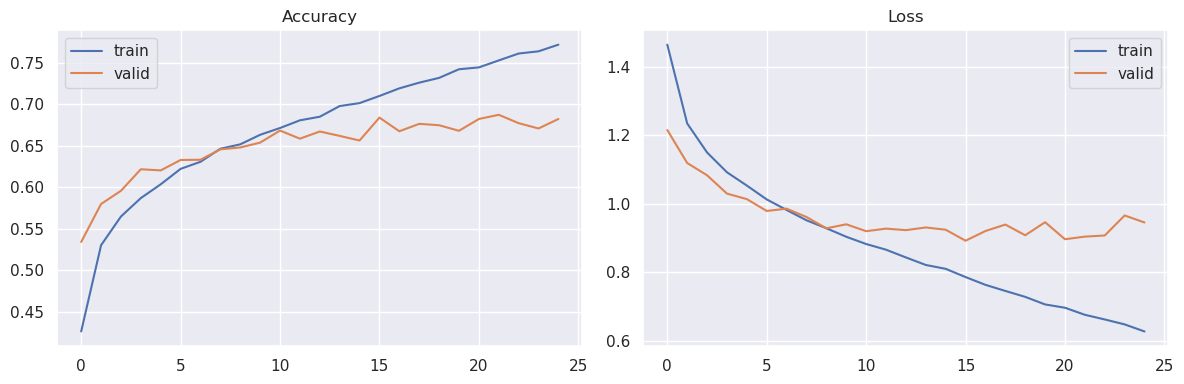://)